In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, cohen_kappa_score
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve,auc
from plotnine import *

Part 1

In [4]:

data = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
data_clean = data.dropna()
# 1 = male and 0 = female
data_clean.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [23]:
#KNN
X = data.drop(columns=["output"])
y = data["output"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
knn = KNeighborsClassifier(n_neighbors=6)
ct = ColumnTransformer(
    [
        ("standardize", StandardScaler(),["age","trtbps","chol","thalach"] ),
        ("onehot", OneHotEncoder(handle_unknown="ignore"),["sex","cp","restecg"])
    ],
    remainder="passthrough" 
)

knn_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("Knn", knn)
    ]
)
k = {"Knn__n_neighbors": np.arange(1,20)}
gscv = GridSearchCV(knn_pipeline, k, cv=5, scoring="roc_auc")
gscv.fit(X,y)
best_k = gscv.best_params_["Knn__n_neighbors"]
best_k_model = Pipeline(
    [
        ("preprecessing",ct),
        ("Knn",KNeighborsClassifier(n_neighbors=best_k))
    ]
)
best_model = best_k_model.fit(X,y)
print(f"Cross-validated ROC AUC of the best model: {gscv.best_score_:}")
y_pred = best_model.predict(X)
cm1 = confusion_matrix(y, y_pred)
cm1

Cross-validated ROC AUC of the best model: 0.8196113174182139
Cross-validated ROC AUC of the best model: 0.8196113174182139


array([[107,  20],
       [ 38, 108]])

Multiple differnt combinations of predictor variables were used in pipelines but the best for purley predictive classification purposes a model where  it included all the of the predictor varibles in the dataset both numerical and categorical provided the best AUC also tuning was preformed to find the best k of values 1-20.

In [24]:
#Logistic Regression
logistic_pipeline = Pipeline(
    [
        ("preprocessing",ct),
        ("Logistic", LogisticRegression(max_iter=500, random_state=42))
    ]
)
param_grid = {"Logistic__C": np.logspace(-3,3,10)}
gscv = GridSearchCV(logistic_pipeline,param_grid, cv=5, scoring="roc_auc")
gscv.fit(X,y)

best_log = gscv.best_params_["Logistic__C"]
best_log_model = Pipeline(
    [
        ("Preprocessing",ct),
        ("Logistic", LogisticRegression(C=best_log, max_iter=500, random_state=42))
    ]
)
final_model_log = best_log_model.fit(X,y)
print(f"Cross-validated ROC AUC of the best model: {gscv.best_score_:}")
y_pred = best_log_model.predict(X)
cm2 = confusion_matrix(y, y_pred)
print(cm2)
logistic_model = final_model_log.named_steps["Logistic"]

coefficients = logistic_model.coef_  
intercept = logistic_model.intercept_  
preprocessor = final_model_log.named_steps["Preprocessing"]
feature_names = preprocessor.get_feature_names_out()
coefficients_df = pd.DataFrame(
    {"Feature": feature_names, "Coefficient": coefficients.flatten()}
)
coefficients_df = coefficients_df.reindex(coefficients_df.Coefficient.abs().sort_values(ascending=False).index)
print("Coefficients with Feature Names:")
print(coefficients_df)
print("\nIntercept:")
print(intercept)



Cross-validated ROC AUC of the best model: 0.8642935455349248
[[ 95  32]
 [ 23 123]]
Coefficients with Feature Names:
                 Feature  Coefficient
6           onehot__cp_0    -1.277997
5          onehot__sex_1    -0.898612
4          onehot__sex_0     0.897716
3   standardize__thalach     0.729486
7           onehot__cp_1     0.545402
8           onehot__cp_2     0.476397
1    standardize__trtbps    -0.297262
9           onehot__cp_3     0.255301
2      standardize__chol    -0.245867
11     onehot__restecg_1     0.244657
0       standardize__age    -0.222244
12     onehot__restecg_2    -0.163495
10     onehot__restecg_0    -0.082059

Intercept:
[0.79431216]
Cross-validated ROC AUC of the best model: 0.8642935455349248
[[ 95  32]
 [ 23 123]]
Coefficients with Feature Names:
                 Feature  Coefficient
6           onehot__cp_0    -1.277997
5          onehot__sex_1    -0.898612
4          onehot__sex_0     0.897716
3   standardize__thalach     0.729486
7           oneho

Using a similar process to the KNN instead we are now using logistic regression but the same steps were taken including standerdization, dummyfying, tuning, and predicting. Now we have some coefficients that we can interperet in the output shown above and a few most important ones seem to be cp of 0 and sex. Holding all else constant reporting a chest pain of 0 decreases your log odds of being diagnosed heart disease by 1.28. Since 0 is female being a female increases you log odds of ebing diagnosed with heart disease by 0.899.

In [25]:
dt_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("DT", DecisionTreeClassifier(random_state=42))
    ]
)

param_grid = {"DT__max_depth": np.arange(1, 21)}
gscv = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring="roc_auc")
gscv.fit(X, y)

best_tree = gscv.best_params_["DT__max_depth"]

best_tree_model = Pipeline(
    [
        ("Preprocessing", ct),
        ("DT", DecisionTreeClassifier(max_depth=best_tree, random_state=42))  
    ]
)

final_model = best_tree_model.fit(X, y)

print(f"Cross-validated ROC AUC of the best model: {gscv.best_score_:.4f}")

y_pred = final_model.predict(X)
cm3 = confusion_matrix(y, y_pred)
cm3


Cross-validated ROC AUC of the best model: 0.7721
Cross-validated ROC AUC of the best model: 0.7721


array([[ 94,  33],
       [ 34, 112]])

Interpretation:
Using the model with the biggest auc_roc which was the logistic model the coefficients from is with the biggest values are ROC , SEX, ans AGE which are the most important predictor varibles for is someone is at risk of a heart attack.

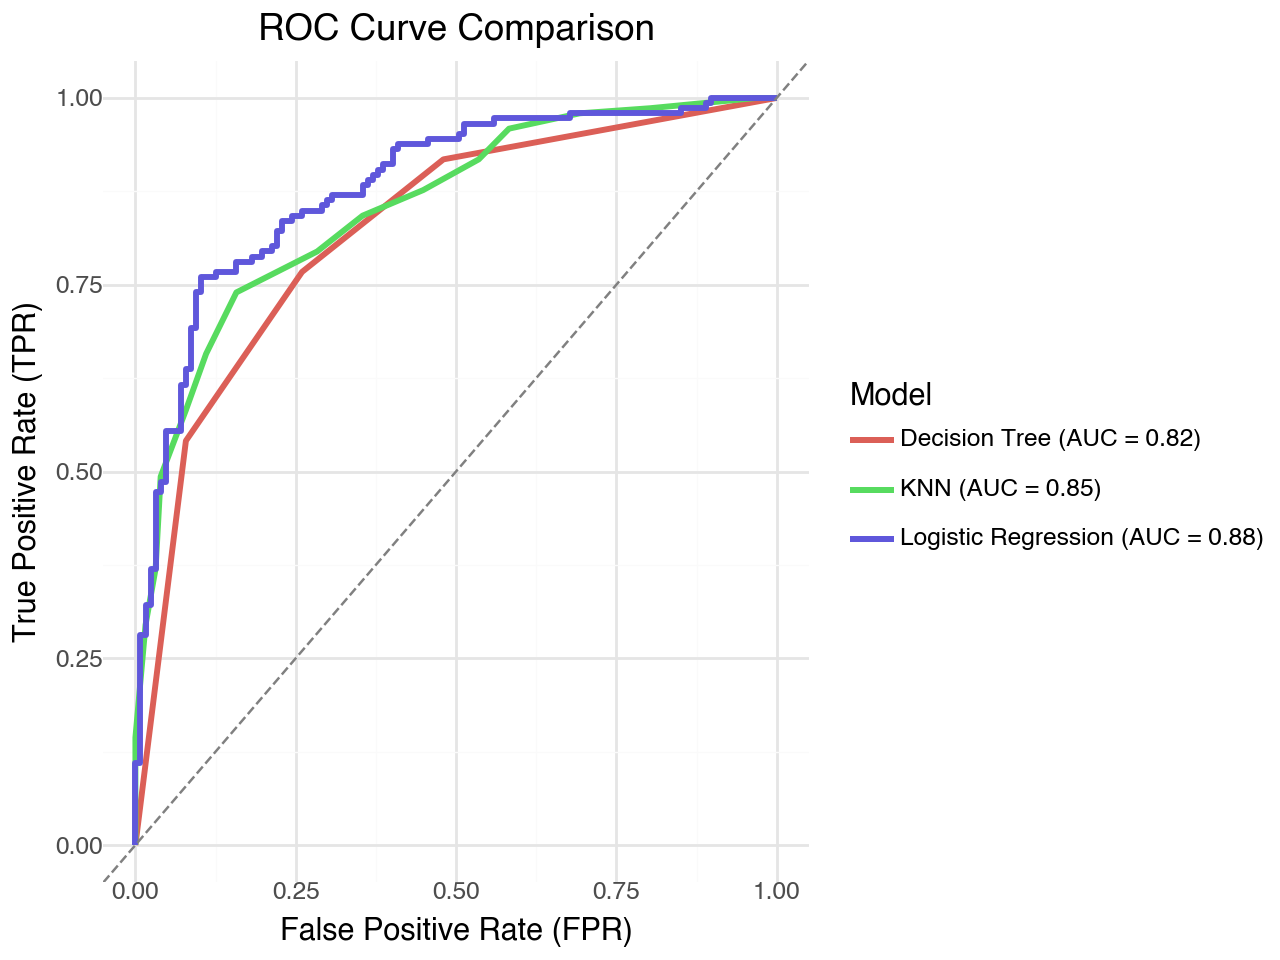

In [26]:

models = {
    "KNN": best_model,
    "Logistic Regression": final_model_log,
    "Decision Tree": final_model
}

roc_data = []

for name, model in models.items():
    y_pred_prob = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    df = pd.DataFrame({"FPR": fpr, "TPR": tpr, "Model": f"{name} (AUC = {roc_auc:.2f})"})
    roc_data.append(df)
roc_df = pd.concat(roc_data, ignore_index=True)

(
    ggplot(roc_df, aes(x="FPR", y="TPR", color="Model")) +
    geom_line(size=1.2) +
    geom_abline(slope=1, intercept=0, linetype="dashed", color="gray") +  # Diagonal line for random guessing
    labs(
        title="ROC Curves for Models",
        x="False Positive Rate (FPR)",
        y="True Positive Rate (TPR)",
        color="Model"
    ) +
    theme_minimal() +
    ggtitle("ROC Curve Comparison")
)


Part 2

In [27]:
def compute_metrics(confusion_matrix):

    tn = confusion_matrix[0, 0]
    fp = confusion_matrix[0, 1]
    fn = confusion_matrix[1, 0]
    tp = confusion_matrix[1, 1]

    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0  
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0  
    tnr = tn / (tn + fp) if (tn + fp) != 0 else 0  

    return {
        "TPR (Recall/Sensitivity)": tpr,
        "Precision (PPV)": precision,
        "TNR (Specificity)": tnr
    }


In [14]:
knn_metrics = compute_metrics(cm1)
knn_metrics

{'TPR (Recall/Sensitivity)': 0.7397260273972602,
 'Precision (PPV)': 0.84375,
 'TNR (Specificity)': 0.84251968503937}

In [15]:
logistic_metrics = compute_metrics(cm2)
logistic_metrics

{'TPR (Recall/Sensitivity)': 0.8424657534246576,
 'Precision (PPV)': 0.7935483870967742,
 'TNR (Specificity)': 0.7480314960629921}

In [16]:
tree_metrics = compute_metrics(cm3)
tree_metrics

{'TPR (Recall/Sensitivity)': 0.7671232876712328,
 'Precision (PPV)': 0.7724137931034483,
 'TNR (Specificity)': 0.7401574803149606}

Part 3

Question 1: For this quesiton I would use true positive rate because it seems most important to correctly claffisy a patient in the right category and then that patient actually be in that category becasue misclassfying someone would result in a lawsuit and they deem that really important. Based on this I would use the logistic regression model because it has the highest TPR rate and that is the metric we want here. This metric would be the best at correctly classifying all the highrisk patients. I would expect the score to be around 85% becasue that was the TPR score.

Question 2: For this question I would use precision because we need to use a metric that does best at classifying heart attack risk with people who are truley at risk. I would reccomend the KNN model becasue it had the highest precision rate. I would expect that the precision to be around 84.37%.

Question 3:  For this quesiton I would use TPR because we are interested in cases of people that actually had heart attacks and we ant to correctly classify them making TPR the best choice. Again I would use the logistic regression model because it had the highest TPR rate. I would expect the metrick to classify them around 85% of the time based on the score.

Question 4: For this I would use the precision because it seems like they want ot see if their new doctors got their diagnosis right so it would make sense that we want to see the people classified most correclty which is overall precision. I would suggest the KNN model becuase it had the highest precision and I would guess that it would habe about 85% accuracuy as it did in the KNN model.

Part 4

In [35]:

ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")
X = ha_validation.drop(columns=["output"])
y = ha_validation["output"]

def evaluate_model(model, X, y, model_name):
    print(f"\nEvaluating {model_name}...")
    
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None
    
    cm = confusion_matrix(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_proba) if y_pred_proba is not None else None
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    
    print(f"Confusion Matrix:\n{cm}")
    print(f"ROC AUC: {roc_auc:.4f}" if roc_auc is not None else "ROC AUC: Not Available")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    return {"ROC AUC": roc_auc, "Precision": precision, "Recall": recall}
logistic_results = evaluate_model(best_log_model, X, y, "Logistic Regression")
knn_results = evaluate_model(best_k_model, X, y, "KNN")
tree_results = evaluate_model(best_tree_model, X, y, "Decision Tree")



Evaluating Logistic Regression...
Confusion Matrix:
[[ 9  2]
 [ 4 15]]
ROC AUC: 0.8900
Precision: 0.8824
Recall: 0.7895

Evaluating KNN...
Confusion Matrix:
[[10  1]
 [ 8 11]]
ROC AUC: 0.8230
Precision: 0.9167
Recall: 0.5789

Evaluating Decision Tree...
Confusion Matrix:
[[10  1]
 [ 5 14]]
ROC AUC: 0.8923
Precision: 0.9333
Recall: 0.7368


Evaluating Logistic Regression...
Confusion Matrix:
[[ 9  2]
 [ 4 15]]
ROC AUC: 0.8900
Precision: 0.8824
Recall: 0.7895

Evaluating KNN...
Confusion Matrix:
[[10  1]
 [ 8 11]]
ROC AUC: 0.8230
Precision: 0.9167
Recall: 0.5789

Evaluating Decision Tree...
Confusion Matrix:
[[10  1]
 [ 5 14]]
ROC AUC: 0.8923
Precision: 0.9333
Recall: 0.7368


KNN model: The ROC AUC was the same from the origional data and this new test data indicating a similar preformance. The precision increased by about .06 but the recall dropped indicating that the model had a harder time indicating true 1 cases in this new validation set.

Logistic: The AUC increased by about 0.03 in this new validation set from our best model from part one. The precision and recall for this model did about 0.05 better and about 0.04 worse idicating the same pattern as in the KNN model.

Tree: The ROC_AUD incerased a lot from this new validation set by .18 and the precision and recall both increased in the validation set. From the three models the tree model out preformed the best in this validation set by the metrics listed above.

Part 5

In [37]:

def evaluate_cohen_kappa(model, X, y, model_name):
    print(f"\nEvaluating Cohen's Kappa for {model_name}...")
    
    y_pred = model.predict(X)
    
    kappa = cohen_kappa_score(y, y_pred)
    print(f"Cohen's Kappa: {kappa:.4f}")
    return kappa
    
logistic_kappa = evaluate_cohen_kappa(best_log_model, X, y, "Logistic Regression")
knn_kappa = evaluate_cohen_kappa(best_k_model, X, y, "KNN")
tree_kappa = evaluate_cohen_kappa(best_tree_model, X, y, "Decision Tree")



Evaluating Cohen's Kappa for Logistic Regression...
Cohen's Kappa: 0.5853

Evaluating Cohen's Kappa for KNN...
Cohen's Kappa: 0.4304

Evaluating Cohen's Kappa for Decision Tree...
Cohen's Kappa: 0.6000


Evaluating Cohen's Kappa for Logistic Regression...
Cohen's Kappa: 0.5853

Evaluating Cohen's Kappa for KNN...
Cohen's Kappa: 0.4304

Evaluating Cohen's Kappa for Decision Tree...
Cohen's Kappa: 0.6000


Cohens kappa is another mteric used for classification but it also adds another level of classification one that is b yrandom chance and is a metric observed from -1,0,1. After some more research it was seen that this is a popular metric that is used when the data is unbalenced, in this case if output had a disproportinate amount of 0 to 1's or visa versa. From our three models the model that had the highest cohen kappa score was the decision tree model followed by the logistic then KNN. I would say that this doesn't change too much about our overall decisions it jsut adds another metric that could be used to evalutate model preformace. Each model could still be used it is more of the data and which model ends up working best and being able to justify that model being used on the various metrics used in this lab.

Chat gpt was used acorss the duration of this lab for general syntax issues and any roadblocks that came along the way after trouble shooting. It wa also used when making the ROC plot for all the models and to make the function for TPR,FPR, and sensitivity. It wa also used for the kohens kappa part to understand what this metric was doing and how to implement it to see how well our models preformed on the validation set.